In [1]:
import os
import tqdm
import math
import torch
import random
import warnings
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, TensorDataset

warnings.filterwarnings("ignore")
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
N_BATCH = 128
LENGTH = 60
N_SERIES = 3

arr = torch.randn(N_BATCH, LENGTH, N_SERIES)

# 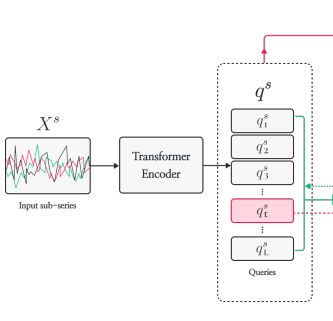

In [ ]:
# Hyper-parameters
d_model = 64
n_head = 8
n_layers = 6
n_memories = 16

# Transformer Architecture
print("[input]", arr.shape)
out = nn.Linear(N_SERIES, d_model)(arr); print(out.shape)
out = out.permute(1, 0, 2); print(out.shape)
enc_layer = nn.TransformerEncoderLayer(d_model = d_model, nhead=8)
out = nn.TransformerEncoder(enc_layer, num_layers=n_layers)(out); print("[Encoder]",out.shape)
qs = out.permute(1, 0, 2); print("[qs]",qs.shape)

# 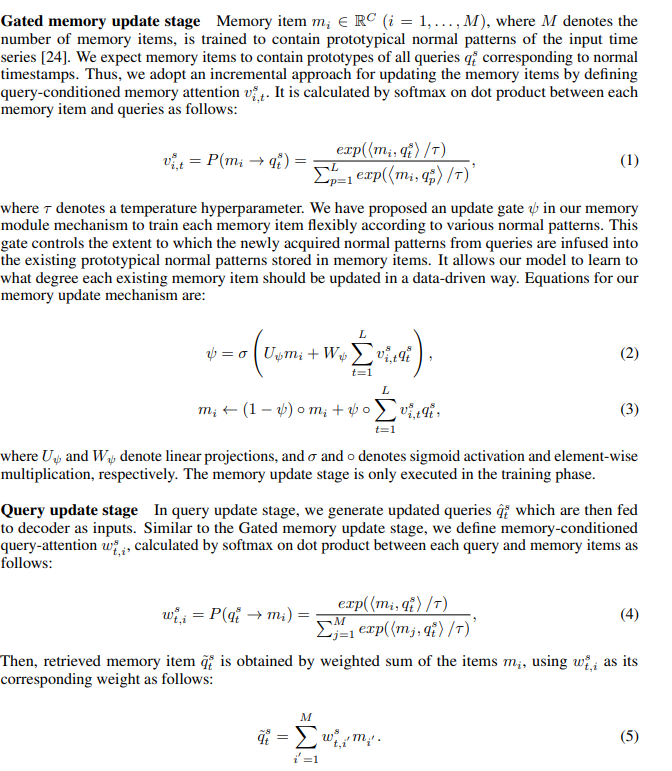

In [50]:
# Memory
from sklearn.cluster import KMeans
q = qs.reshape(-1, d_model).detach().numpy()
kmeans = KMeans(n_clusters=n_memories, random_state=42).fit(q)
memory = torch.tensor(kmeans.cluster_centers_, dtype=torch.float)
## memory update
print("-----[Memory Updating]-----")
s = qs@memory.T; print(s.shape)
s = s.permute(0, 2, 1); print(s.shape)
v = nn.Softmax(dim = 2)(s); print(v.shape)
r = v@qs; print(r.shape)
U_psi = nn.Linear(d_model, d_model, bias = False)
W_psi = nn.Linear(d_model, d_model, bias = False)
r_mean = r.mean(dim=0)
psi = U_psi(memory) + W_psi(r_mean); print(psi.shape)
memory = (1 - psi)*memory + psi*r_mean; print("[Memory Update]",memory.shape)
## retrieve memory
print("-----[Memory Retrieving]-----")
rr = qs@memory.T; print(rr.shape)
rr = nn.Softmax(dim=2)(rr); print(rr.shape)
q_telta = rr@memory; print("[q_telta]", q_telta.shape)
q_hat = torch.cat([qs, q_telta], dim = -1); print("[q_hat]", q_hat.shape)

# Weak Decoder
print("-----[Decoding]")
out = nn.Linear(2*d_model, d_model)(q_hat); print(out.shape)
recon = nn.Linear(d_model, N_SERIES)(out); print(recon.shape)

[input] torch.Size([128, 60, 3])
torch.Size([128, 60, 64])
torch.Size([60, 128, 64])
[Encoder] torch.Size([60, 128, 64])
[qs] torch.Size([128, 60, 64])
-----[Memory Updating]-----
torch.Size([128, 60, 16])
torch.Size([128, 16, 60])
torch.Size([128, 16, 60])
torch.Size([128, 16, 64])
torch.Size([16, 64])
[Memory Update] torch.Size([16, 64])
-----[Memory Retrieving]-----
torch.Size([128, 60, 16])
torch.Size([128, 60, 16])
[q_telta] torch.Size([128, 60, 64])
[q_hat] torch.Size([128, 60, 128])
-----[Decoding]
torch.Size([128, 60, 64])
torch.Size([128, 60, 3])


In [45]:
L_recon = torch.mean((arr - recon)**2)
L_entropy = torch.mean(torch.sum((torch.sum(-rr*torch.log(rr+1e-8), dim = -1)), dim = -1))
Loss = L_recon + .01*L_entropy